# Temporal Analysis of LANL Authentication Dataset

## Introduction

The Los Alamos National Laboratory (LANL) provides an anonymized dataset of successful authentication events from users to computers over a nine-month period. This dataset contains **708,304,516** authentication events and serves as a rich resource for understanding user behavior in a computer network environment.

### Dataset Description

Each line in the dataset represents a successful authentication in the format:


- **time**: A timestamp indicating when the authentication occurred, represented as seconds since epoch (UNIX time).
- **user**: An anonymized identifier for the user, represented as `U` followed by a unique number.
- **computer**: An anonymized identifier for the computer, represented as `C` followed by a unique number.

The dataset contains **11,362** unique users and **22,284** unique computers.

### Objective

The primary objectives of this analysis are:
1. **Time Series Analysis**: To identify trends in user logins over time, including peak login hours and user activity patterns.
2. **Sessionization**: To aggregate authentication events into user sessions and analyze user behavior, including session lengths and frequency of access.

---

## Step 1: Load the Dataset

We will begin by loading the dataset from its compressed `.bz2` format and converting the timestamp into a readable format.


In [1]:
import pandas as pd

# Define the input file path
input_file_path = r"C:\Users\USER\UEBA_Project\behavioral_profiling\data\raw\lanl-auth-dataset-sampled.csv"

# Load the dataset without overriding column names
data = pd.read_csv(input_file_path)

# Convert the 'time' column to a datetime format
data['time'] = pd.to_datetime(data['time'], unit='s')

print(data.head())  # Display the first few rows of the dataset


                 time   user computer
0 1970-02-07 16:43:58  U4347    C8763
1 1970-02-21 17:36:13  U4082    C4695
2 1970-02-05 15:11:09  U7139    C8144
3 1970-02-20 23:34:03  U3505    C3947
4 1970-01-30 22:38:47    U77      C78


## Step 2: Time Series Analysis
### 2.1 Analyzing Peak Login Hours
To understand when users are most active, we can aggregate login counts by hour.

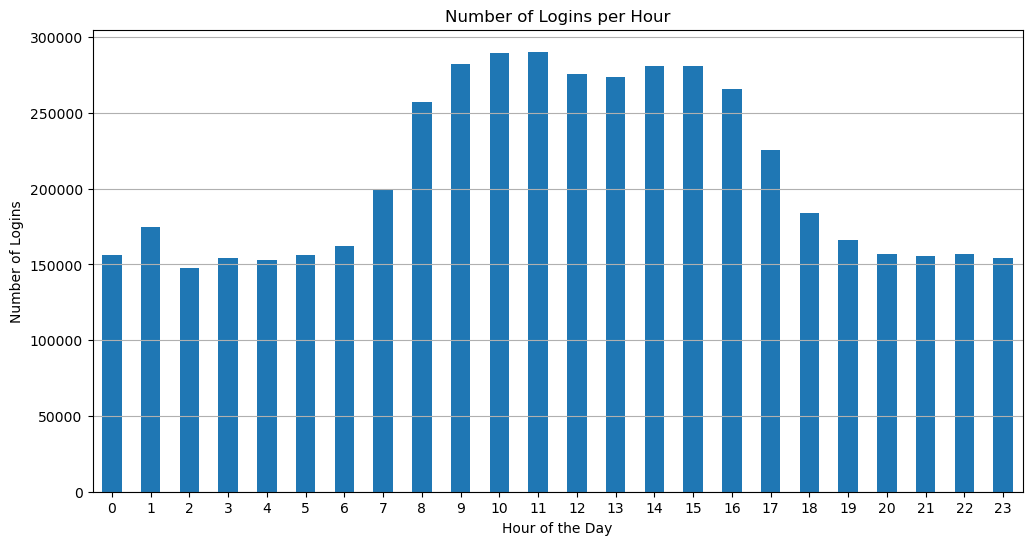

In [2]:
# Extract hour from the time
data['hour'] = data['time'].dt.hour

# Count the number of logins per hour
login_counts_per_hour = data['hour'].value_counts().sort_index()

# Plot the login counts per hour
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
login_counts_per_hour.plot(kind='bar')
plt.title('Number of Logins per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Logins')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


## 2.2 User Activity Patterns
Next, we will analyze the login activity of individual users to identify the most active ones.

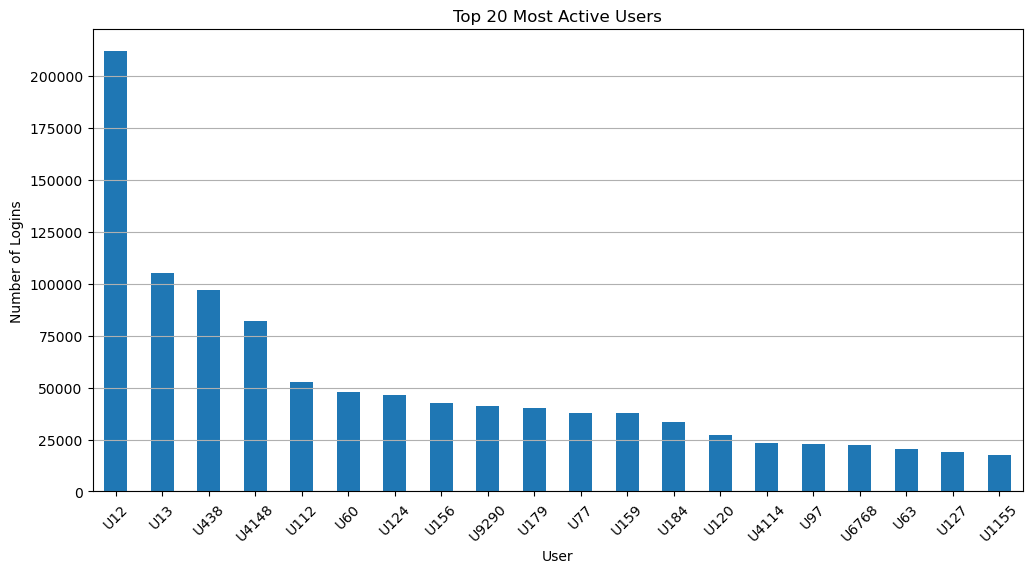

In [3]:
# Count the number of logins per user
login_counts_per_user = data['user'].value_counts()

# Plot the top 20 most active users
top_users = login_counts_per_user.head(20)

plt.figure(figsize=(12, 6))
top_users.plot(kind='bar')
plt.title('Top 20 Most Active Users')
plt.xlabel('User')
plt.ylabel('Number of Logins')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## Step 3: Sessionization
To define user sessions, we will group authentication events and analyze session lengths based on a defined time window.

### 3.1 Setting Up Session Timeout
We will set a threshold for session timeout (e.g., 30 minutes) to determine when a new session starts.

In [4]:
# Set a threshold for session timeout (e.g., 30 minutes)
session_timeout = pd.Timedelta(minutes=30)

# Sort the data by user and time
data = data.sort_values(by=['user', 'time'])


### 3.2 Creating User Sessions
We will define a function to create sessions and analyze user behavior.

In [5]:
# Define a function to create sessions
def create_sessions(group):
    group['session_start'] = group['time']
    group['session_end'] = group['time']
    
    # Calculate time differences between consecutive logins
    group['time_diff'] = group['time'].diff().fillna(pd.Timedelta(seconds=0))
    
    # Start a new session if the time difference exceeds the session timeout
    group['new_session'] = (group['time_diff'] > session_timeout).astype(int).cumsum()
    
    # Group by user and new_session to get session details
    sessions = group.groupby('new_session').agg(
        user=('user', 'first'),  # Retain user information
        session_start=('time', 'min'),
        session_end=('time', 'max'),
        session_length=('time', lambda x: (x.max() - x.min()).total_seconds())
    )
    
    return sessions

# Apply sessionization for each user
user_sessions = data.groupby('user').apply(create_sessions).reset_index(drop=True)

print(user_sessions.head())  # Display the first few sessions


  user       session_start         session_end  session_length
0   U1 1970-01-29 00:00:17 1970-01-29 21:34:52         77675.0
1   U1 1970-01-29 22:09:51 1970-02-02 01:24:55        270904.0
2   U1 1970-02-02 02:10:02 1970-02-02 02:25:15           913.0
3   U1 1970-02-02 03:00:32 1970-02-02 04:19:51          4759.0
4   U1 1970-02-02 05:34:54 1970-02-02 05:34:54             0.0


C:\Users\USER\AppData\Local\Temp\ipykernel_18000\4230308229.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_sessions = data.groupby('user').apply(create_sessions).reset_index(drop=True)


## Step 4: Analyzing Sessions
Finally, we can analyze the session counts and lengths to gain insights into user behavior.

### 4.1 Counting Sessions per User
Let's visualize the number of sessions for the most active users.

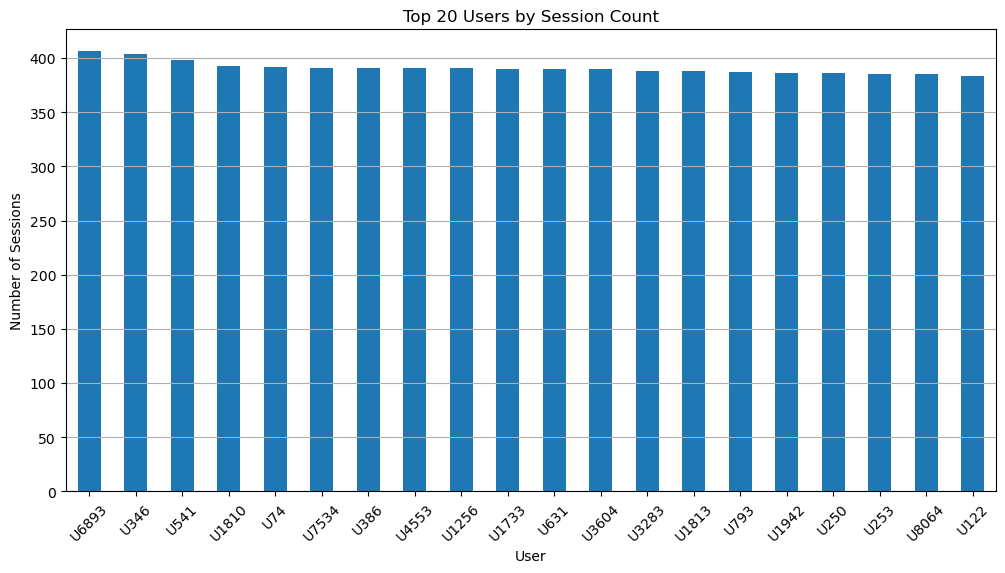

In [6]:
# Count the number of sessions per user
session_counts_per_user = user_sessions['user'].value_counts()

# Plot the top 20 users with the most sessions
top_session_users = session_counts_per_user.head(20)

plt.figure(figsize=(12, 6))
top_session_users.plot(kind='bar')
plt.title('Top 20 Users by Session Count')
plt.xlabel('User')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


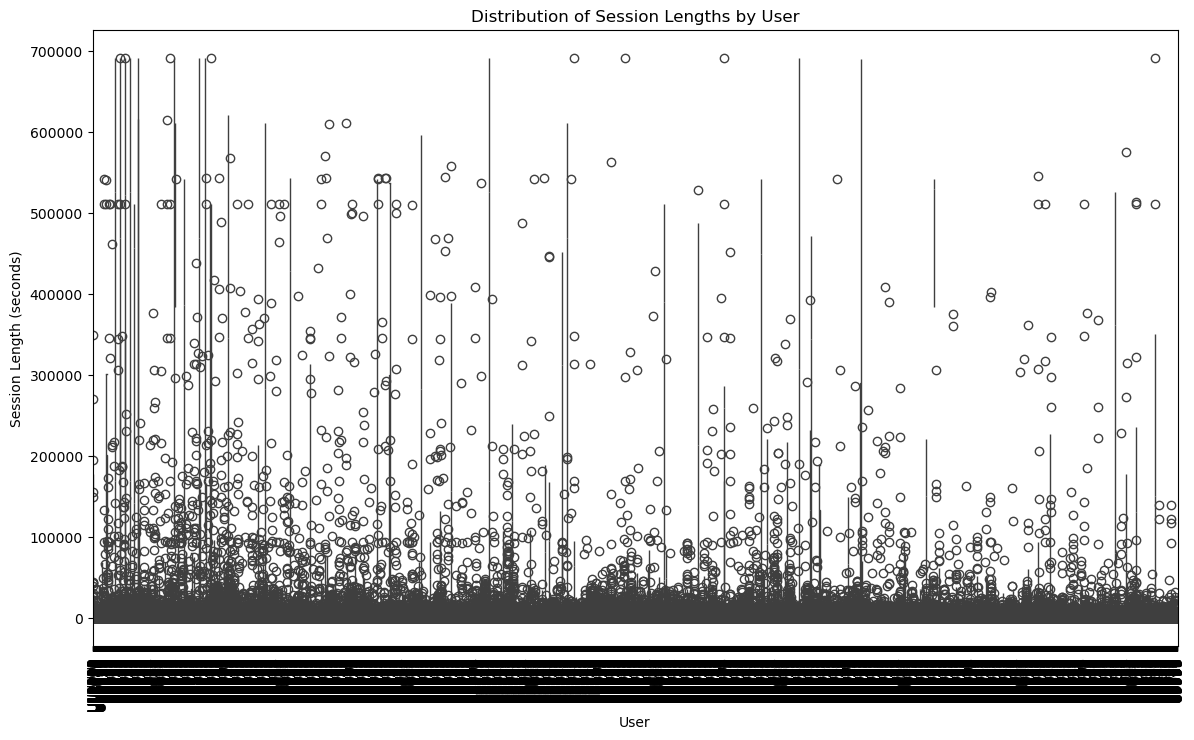

In [8]:
# Box plot of session lengths for each user
import seaborn as sns
plt.figure(figsize=(14, 8))
sns.boxplot(data=user_sessions, x='user', y='session_length')
plt.title('Distribution of Session Lengths by User')
plt.xlabel('User')
plt.ylabel('Session Length (seconds)')
plt.xticks(rotation=90)
plt.show()


### 4.2 Analyzing Session Lengths
We can also visualize the distribution of session lengths.

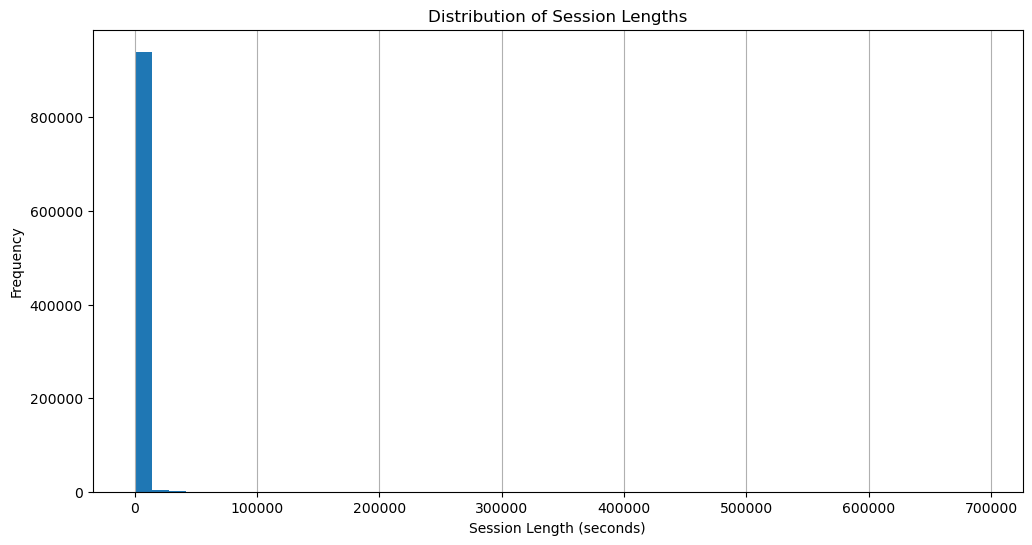

In [9]:
# Analyze session lengths
plt.figure(figsize=(12, 6))
user_sessions['session_length'].hist(bins=50)
plt.title('Distribution of Session Lengths')
plt.xlabel('Session Length (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()
